In [5]:
import tensorflow as tf
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Downlaod and Save Resnet 50

- To use Resnet50 trained on imagenet as a base for our model, we downloaded it from keras and saved the model and its weights.

In [4]:
# This was downloaded and saved already and is not necessary anymore
save_resnet_50 = False

if save_resnet_50:
    resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    resnet_50.save("./models/resnet50")
    resnet_50.save_weights("./models/resnet50/checkpoints/")

# Create Test Data

- We used the Animal Image Classification Dataset from Kaggle. 
- After downloading the dataset, we selected the first 10% of images of each class and moved them to a folder exclusively used for testing. 



PIYUSHKUMAR.18. (n.d). Animal Image Classification Dataset, Version 1. Retrieved December 6 2022 from https://www.kaggle.com/datasets/piyushkumar18/animal-image-classification-dataset?datasetId=1112806

In [3]:
# This code moved 10% of the images to a different folder and should not be run again
seperate_test_data = False

from os import walk, rename
path = "./data/Animal Image Dataset/"

if seperate_test_data:
    d = []
    for (dirpath, dirnames, filenames) in walk(path):
        d.extend(dirnames)
        break

    for folder in d:
        f = []
        c_path = f"{path}{folder}"
        for (dirpath, dirnames, filenames) in walk(c_path):
            f.extend(filenames)
            break
        for ff in f[0:len(f)//10]:
            #rename(f"{path}{folder}/{ff}", f"{path}test_data/{folder}/{ff}") # this moves the files # this is commented out to reduce the risk of running this again 
            pass

# Create Basic Model Template 

Basic Process
- We first trained the most basic model (i.e., resnet + flatten + dense[12]). 
- Afterwards we developed a more complex model architecture (i.e., resnet + maxpool2d + dropout + dense[24] + dense[12]) and compared its training statistics - train accuracy, train loss, validation accuracy, validation loss - with those from the most basic model.  
- The more complex model outperformed the basic model aand we used it as our base for tuning. 
- During tuning we systematically added additional architectural facets or varied existing hyperparameters, trained the new model, compared it with the previous model and repeated this process with the better performing model. 
- Because we want to investigate the generalizability of networks we focused on reducing overfit by trying to minimize validation loss. But we also considered accuracy and training time for making the final decision.

Detailed Tuning Process
- First, we added early stopping to the model. Initially we used a patience of 2 and min delta of .001 because we saw in earlier training cycles without early stopping that validation loss appeared to increase within a short time. 
- Second, we added an adaptive learning rate to the model. Specifically, we reduce the learning rate by 10% every epoch.  
- After adding adaptive learning, we retuned the early stoppping parameters and ended up using a patience of 5 and a min delta of .0001 because together with the adaptive learning rate the model tended to find more optimal solutions after a couple of epochs. 
- Third, we took out the maxpool2d layer, which we originally included to reduce the number of trainable parameters and thus reduce training time. Taking it out lead to greatly increased performance ata a cost of longer training time. But as training time was still within reason (~10min), we left it in. 
- Fourth, we took out the first dense layer, which lead to worse performance. Then we reduced the number of units in this layer from 24 to 12, which lead to a big improvement in validation loss. 
- Fifth, we increased dropout in the first dense layer from 30% to 50%, which further reduced validation loss.
- Sixth, added L1 and L2 regularization with standard values to the weigths of the first dense layer, which reduced validation loss slightly. 
- Seventh, we realized that the gpu was only running at 4% and increased the batch-size used during training from 32 to 320. The gpu was still only using about 6% of its capacity, but this lead to the 16gb RAM maxing out before training could be completed. Nontheless even incomplete training produced very large improvements in validation loss. Thus we reduced the batch size to 250, which is still managable by the 16gb of RAM and lead to very good training accuracy (0.9973), training loss (0.0664), validation accuracy (0.9153) and acceptable validation loss (0.9033) after 24 training epochs taking about 6 minutes. 

Initial Testing
- We tested the performance of this model on the test set and it achieved 90.38% accuracy with a loss of 1.0712.
- We concluded that this is satisfactory and decided to use this model architecture for our exploratory study of generizability.   

## Load Resnet50 as Base

- From now on we load the Resnet50 and its weights from our own folder and not from keras. Resnet serves as the base for our model and is set to non-trainable. 

In [19]:
resnet_50 = tf.keras.models.load_model("./models/resnet50")
resnet_50.load_weights("./models/resnet50/checkpoints/")
resnet_50.trainable = False # freeze layers

## Early Stopping and Adaptive Learning

We implemented early stopping and adaptive learning as callbacks. Adaptive learning would reduce the learning rate used by the ADAM optimizer by 10% every eopoch starting from the default learning rate of 0.001.

In [20]:
# early stopping and adaptive learning are implemented as callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = .0001,
    restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch == 0:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
adaptive_learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

## High Level Overview of the Model Development

- Below you can see the basic model and more complicated model before tuning, and the final model after tuning. 
- The final version is compiled using the ADAM optimizer with default parameters. We use sparse-categorical-crossentropy to calculate loss according to the softmax classification in the final layer.  

In [21]:
# Basic Model - This was our baseline before the more complicated model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    resnet_50,
    layers.Dense(12, activation="softmax")
])

# More Complicated Model - This was our baseline for tuning
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    resnet_50,
    layers.MaxPool2D(pool_size=3, strides=1, padding='valid'),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(24),
    layers.Dense(12, activation="softmax")
])

# Final Model - This is the final result after tuning
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    resnet_50,
    layers.Flatten(),
    layers.Dropout(0.5), 
    layers.Dense(12, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)), 
    layers.Dense(12, activation="softmax")
])

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 12)                614412    
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
Total params: 24,202,280
Trainable params: 614,568
Non-trainable params: 23,587,712
_________________________________________________________________


## Save the Final Model

- We want to use the final model architecture for our future testing and saved it so we can consistently load it in the future.

In [2]:
# This does not need to happen again
save_model_template = False

if save_model_template: 
    model.save("./models/base_model_template")
    model.save("./models/base_model_template/checkpoints/")

# Train Models

- We trained six different models on different versions of the dataset (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise).

In [34]:
# verify gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Normalization and Cache Buffer

- EXPLANATION

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

## Normal Model

- This model was trained on the original dataset.

### Load Data

- We load the images with a 150x150 size because REASON
- As indicated before, we use a batch size of 250 because it is large enough to produce good results, but small enought that the RAM can handle it.
- We use 20% of the data for validation. 
- To improve reproducability we use a seed in the data pipeline. 

In [23]:
data_dir = "./data/Animal Image Dataset"
image_height = 150
image_width = 150
batch_size = 250 # RAM can handle this and it leads to good results

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
  )

# Normalize pixel values between 0 and 255
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))

# Cach Buffer
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15462 files belonging to 12 classes.
Using 12370 files for training.
Found 15462 files belonging to 12 classes.
Using 3092 files for validation.


### Train Model

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  batch_size=batch_size,
  callbacks=[early_stopping, adaptive_learning]
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, :].plot()

# Run Tests On All Models

- We tested all models on all versions of the test data (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise).

## Load All Test Data Sets

- First all test data (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise) sets have to be loaded.

In [27]:
all_test_sets = {}
test_set_dirs = ["normal_test_data", "gblur_test_data", "gnoise_test_data", "expo_test_data", "mblur_test_data", "jpgc_test_data"]

In [ ]:
for tdir in test_set_dirs:
    test_data_dir = f"./data/{tdir}"
    all_test_sets[tdir] = tf.keras.utils.image_dataset_from_directory(
        test_data_dir,
        seed=123,
        image_size=(image_height, image_width),
        batch_size=batch_size
        )

## Run Tests

- Each model evaluates each dataset and the results are saved. 

In [31]:
test_results = {}
model_dirs = []

In [32]:
# Load Model
for mdir in model_dirs:
    model_dir = f"./models/{mdir}"
    model = tf.keras.models.load_model(model_dir)
    model.load_weights(f"{model_dir}/checkpoints/")

    # Run Tests     
    test_results[mdir] = {}
    for test_set in all_test_sets:
        test_results["normal_model"][test_set] = model.evaluate(all_test_sets[test_set])

7/7 [==============================] - 11s 278ms/step - loss: 1.1386 - accuracy: 0.9061


# RANDOM STUFF

8/8 [==============================] - 1s 37ms/step


ValueError: num must be 1 <= num <= 10, not 11

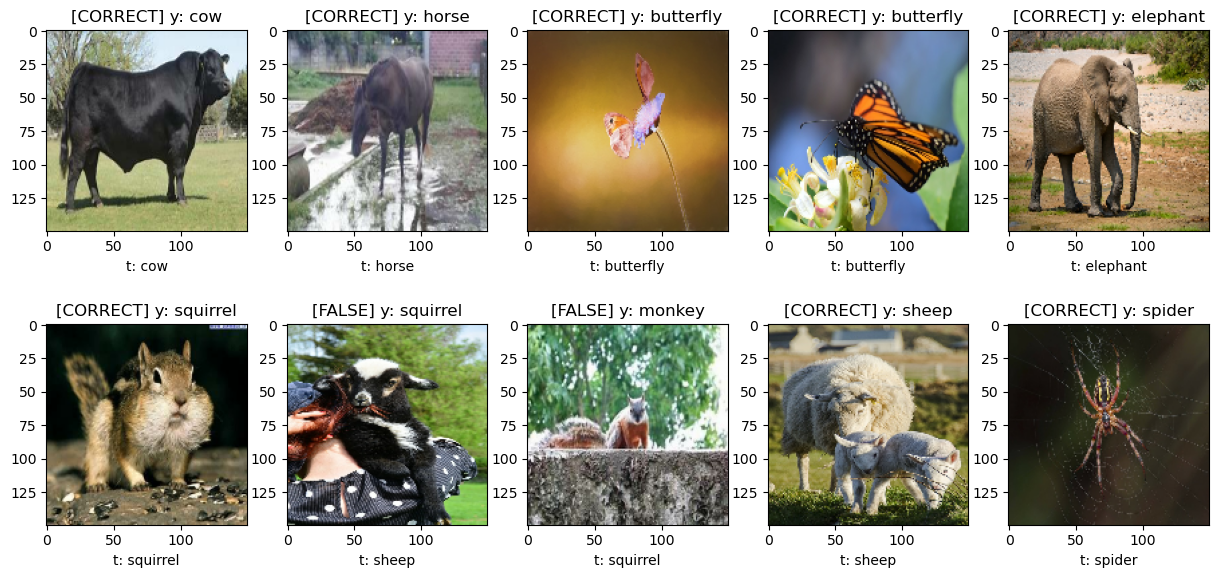

In [100]:
class_names = test_ds.class_names
batch = test_ds.take(1)
plt.figure(figsize=(15,7))
for images, labels in batch:
    prediction = model.predict(images)
    for i in range(batch_size):
        y = class_names[np.argmax(prediction[i])]
        t = class_names[labels[i]]
        if y == t:
            title = f"[CORRECT] y: {y}"
        else:
            title = f"[FALSE] y: {y}"
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.xlabel(f"t: {t}")

# Save Model

In [109]:
model.save("./models/test_model")
model.save("./models/test_model/checkpoints/")

INFO:tensorflow:Assets written to: ./models/test_model\assets


INFO:tensorflow:Assets written to: ./models/test_model\assets


INFO:tensorflow:Assets written to: ./models/test_model/checkpoints/assets


INFO:tensorflow:Assets written to: ./models/test_model/checkpoints/assets
